## Overview

All modules in `AdaptiveResonance.jl` are designed to handle incremental and batch training.
In fact, ART modules are generally incremental in their implementation, so their batch methods wrap the incremental ones and handle preprocessing, etc.
For example, DDVFA can be run incrementally (i.e. with one sample at a time) with custom algorithmic options and a predetermined data configuration.

!!! note
    In the incremental case, it is necessary to provide a data configuration if the model is not pretrained because the model has no knowledge of the boundaries and dimensionality of the data, which are necessary in the complement coding step.
    For more info, see the guide in the docs on incremental vs. batch.

## Data Setup

We begin with importing AdaptiveResonance for the ART modules and MLDatasets for some data utilities.

In [1]:
using AdaptiveResonance # ART
using MLDatasets        # Iris dataset
using MLDataUtils       # Shuffling and splitting
using Printf            # Formatted number printing

We will download the Iris dataset for its small size and benchmark use for clustering algorithms.

In [2]:
# Get the iris dataset as a DataFrame
iris = Iris()
# Manipulate the features and labels into a matrix of features and a vector of labels
features, labels = Matrix(iris.features)', vec(Matrix{String}(iris.targets))

([5.1 4.9 … 6.2 5.9; 3.5 3.0 … 3.4 3.0; 1.4 1.4 … 5.4 5.1; 0.2 0.2 … 2.3 1.8], ["Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa", "Iris-setosa"  …  "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica", "Iris-virginica"])

Because the MLDatasets package gives us Iris labels as strings, we will use the `MLDataUtils.convertlabel` method with the `MLLabelUtils.LabelEnc.Indices` type to get a list of integers representing each class:

In [3]:
labels = convertlabel(LabelEnc.Indices{Int}, labels)
unique(labels)

3-element Vector{Int64}:
 1
 2
 3

Next, we will create a train/test split with the `MLDataUtils.stratifiedobs` utility:

In [4]:
(X_train, y_train), (X_test, y_test) = stratifiedobs((features, labels))

(([6.5 5.4 … 6.5 4.4; 3.2 3.4 … 3.0 3.0; 5.1 1.5 … 5.5 1.3; 2.0 0.4 … 1.8 0.2], [3, 1, 1, 2, 3, 3, 1, 2, 2, 3  …  1, 3, 1, 2, 3, 1, 3, 3, 3, 1]), ([5.7 6.8 … 6.3 5.6; 2.5 3.0 … 3.4 2.5; 5.0 5.5 … 5.6 3.9; 2.0 2.1 … 2.4 1.1], [3, 3, 2, 1, 3, 1, 1, 3, 3, 3  …  1, 2, 3, 1, 2, 1, 2, 1, 3, 2]))

## Incremental vs. Batch

### Setup

Now, we can create several modules to illustrate training one in batch and one incrementaly.

In [5]:
# Create several modules for batch and incremental training.
# We can take advantage of the options instantiation method here to use the same options for both modules.
opts = opts_DDVFA(rho_lb=0.6, rho_ub=0.75)
art_batch = DDVFA(opts)
art_incremental = DDVFA(opts)

DDVFA(opts_DDVFA
  rho_lb: Float64 0.6
  rho_ub: Float64 0.75
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  method: String "single"
  display: Bool true
  max_epoch: Int64 1
  gamma_normalization: Bool true
, opts_FuzzyART
  rho: Float64 0.75
  alpha: Float64 0.001
  beta: Float64 1.0
  gamma: Float64 3.0
  gamma_ref: Float64 1.0
  display: Bool false
  max_epochs: Int64 1
  gamma_normalization: Bool true
, DataConfig(false, Float64[], Float64[], 0, 0), 0.0, FuzzyART[], Int64[], 0, 0, 0.0, 0.0)

For the incremental version, we must setup the data configuration in advance.
In batch mode, this is done automatically based upon the provided data, but the incremental variant has not way of knowing the bounds of the individual features.
We *could* preprocess the data and set the data configuration with `art.config = DataConfig(0, 1, 4)`, which translates to the data containing four features  that *all* range from 0 to 1.
This would be done in scenarios where we have either done some preprocessing on the data or have prior knowledge about the bounds of individual features.
However, in this example we will let the module determine the bounds with the convenience method `data_setup!`:

In [6]:
# Setup the data config on all of the features.
data_setup!(art_incremental.config, features)

4-element Vector{Float64}:
 7.9
 4.4
 6.9
 2.5

### Training

We can train in batch with a simple supervised mode by passing the labels as a keyword argument.

In [7]:
y_hat_batch_train = train!(art_batch, X_train, y=y_train)
println("Training labels: ",  size(y_hat_batch_train), " ", typeof(y_hat_batch_train))

[ Info: Training DDVFA
0.0%┣                                              ┫ 0/105 [00:00<00:-5, -0s/it]
Ep: 1, ID: 1, Cat: 0 1.0%┣▏                    ┫ 1/105 [00:01<Inf:Inf, InfGs/it]
Ep: 1, ID: 6, Cat: 4 5.7%┣█▌                        ┫ 6/105 [00:01<00:17, 6it/s]
Ep: 1, ID: 105, Cat: 12 100.0%┣█████████████████┫ 105/105 [00:01<00:00, 119it/s]
Training labels: (105,) Vector{Int64}


We can also train incrementally with the same method, being careful that we pass a vector features and a single integer as the labels

In [8]:
# Get the number of training samples
n_train = length(y_train)
# Create a container for the training output labels
y_hat_incremental_train = zeros(Int, n_train)
# Iterate over all training samples
for ix = 1:length(y_train)
    sample = X_train[:, ix]
    label = y_train[ix]
    y_hat_incremental_train[ix] = train!(art_incremental, sample, y=label)
end

### Testing

We can then classify both networks and check that their performances are equivalent.
For both, we will use the best-matching unit in the case of complete mismatch (see the docs on Mismatch vs. BMU)

In [9]:
# Classify one model in batch mode
y_hat_batch = AdaptiveResonance.classify(art_batch, X_test, get_bmu=true)

# Classify one model incrementally
n_test = length(y_test)
y_hat_incremental = zeros(Int, n_test)
for ix = 1:n_test
    y_hat_incremental[ix] = AdaptiveResonance.classify(art_incremental, X_test[:, ix], get_bmu=true)
end

# Check the shape and type of the output labels
println("Batch testing labels: ",  size(y_hat_batch), " ", typeof(y_hat_batch))
println("Incremental testing labels: ",  size(y_hat_incremental), " ", typeof(y_hat_incremental))

[ Info: Testing DDVFA
0.0%┣                                               ┫ 0/45 [00:00<00:-2, -0s/it]
Ep: 1, ID: 1, Cat: 12 2.2%┣▌                    ┫ 1/45 [00:00<Inf:Inf, InfGs/it]
Ep: 1, ID: 45, Cat: 12 100.0%┣████████████████████┫ 45/45 [00:00<00:00, 834it/s]
Batch testing labels: (45,) Vector{Int64}
Incremental testing labels: (45,) Vector{Int64}


Finally, we check the performance (number of correct classifications over total number of test samples) for both models, verifying that they produce the same results.

In [10]:
# Calculate performance on training data, testing data, and with get_bmu
perf_train_batch = performance(y_hat_batch_train, y_train)
perf_train_incremental = performance(y_hat_incremental_train, y_train)
perf_test_batch = performance(y_hat_batch, y_test)
perf_test_incremental = performance(y_hat_incremental, y_test)

# Format each performance number for comparison
@printf "Batch training performance: %.4f\n" perf_train_batch
@printf "Incremental training performance: %.4f\n" perf_train_incremental
@printf "Batch testing performance: %.4f\n" perf_test_batch
@printf "Incremental testing performance: %.4f\n" perf_test_incremental

Batch training performance: 1.0000
Incremental training performance: 1.0000
Batch testing performance: 0.9333
Incremental testing performance: 0.9333


## Visualization

So we showed that the performance and behavior of modules are identical in incremental and batch modes.
Great!
Sadly, illustrating this point doesn't lend itself to visualization in any meaningful way.
Nonetheless, we would like a pretty picture at the end of the experiment to verify that these identical solutions work in the first place.
Sanity checks are meaningful in their own right, right?

To do this, we will reduce the dimensionality of the dataset to two dimensions and show in a scatter plot how the modules classify the test data into groups.
This will be done with principal component analysis (PCA) to cast the points into a 2-D space while trying to preserve the relative distances between points in the higher dimension.
The process isn't perfect by any means, but it suffices for visualization.

In [11]:
# Import visualization utilities
using Printf            # Formatted number printing
using MultivariateStats # Principal component analysis (PCA)
using Plots             # Plotting frontend

# Train a PCA model
M = fit(PCA, features; maxoutdim=2)

# Apply the PCA model to the testing set
X_test_pca = transform(M, X_test)

2×45 Matrix{Float64}:
 -1.34459   -2.16538  -1.33104  2.64832   …  2.54269   -2.14499   -0.0432464
 -0.776415   0.21528   0.24467  0.319137     0.586281   0.138907  -0.581489

Now that we have the test points cast into a 2-D set of points, we can create a scatter plot that shows how each point is categorized by the modules.

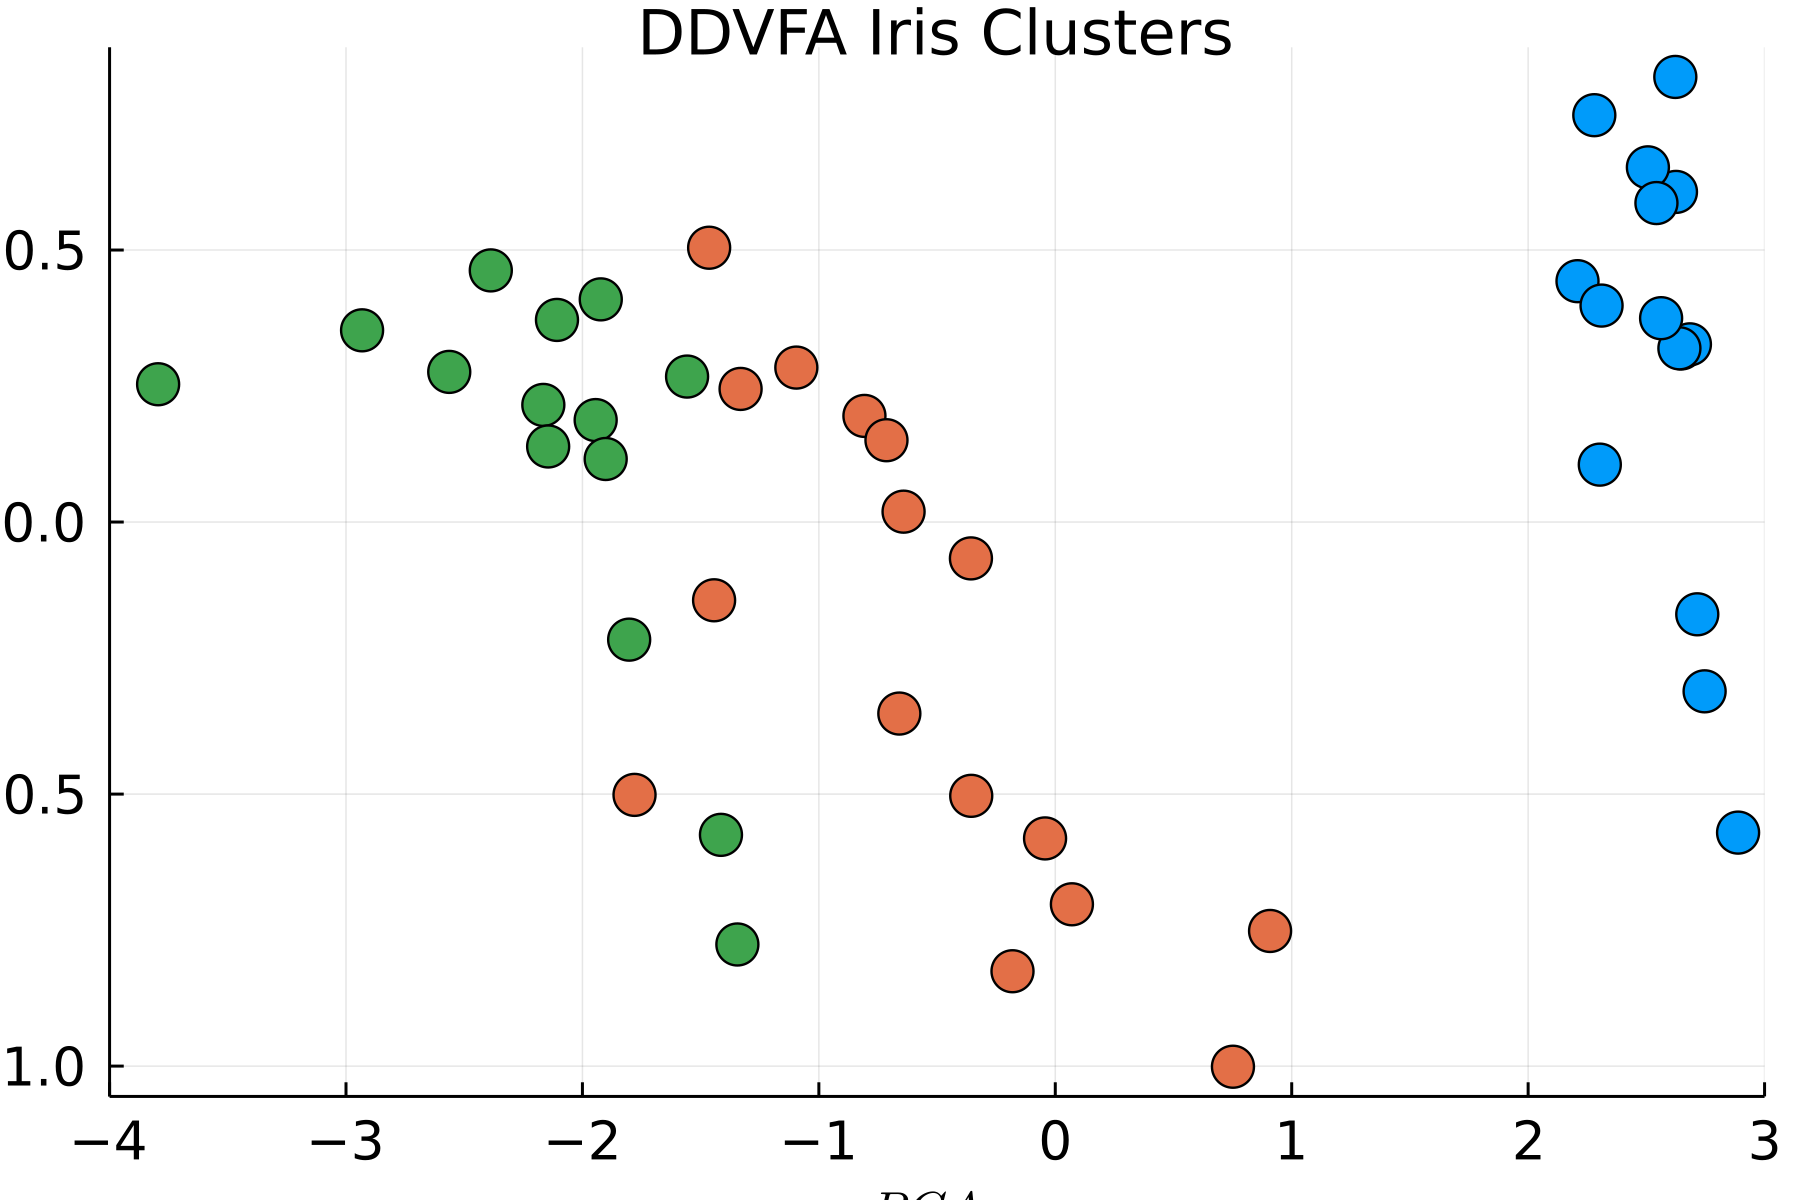

In [12]:
# Create a scatterplot object from the data with some additional formatting options
scatter(
    X_test_pca[1, :],       # PCA dimension 1
    X_test_pca[2, :],       # PCA dimension 2
    group = y_hat_batch,    # labels belonging to each point
    markersize = 8,         # size of scatter points
    legend = false,         # no legend
    xtickfontsize = 12,     # x-tick size
    ytickfontsize = 12,     # y-tick size
    dpi = 300,              # Set the dots-per-inch
    xlims = :round,         # Round up the x-limits to the nearest whole number
    xlabel = "\$PCA_1\$",   # x-label
    ylabel = "\$PCA_2\$",   # y-label
    title = (@sprintf "DDVFA Iris Clusters"),   # formatted title
)

This plot shows that the DDVFA modules do well at identifying the structure of the three clusters despite not achieving 100% test performance.

In [13]:
png("assets/incremental-batch-cover") #hide

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*